In [2]:
# PART 1 — Load & clean the AirBnB dataset (self-contained, idempotent)
import pandas as pd
import numpy as np
from pathlib import Path

#paths
RAW_PATHS = [Path("data/airbnb_hw.csv"), Path("/mnt/data/airbnb_hw.csv")]
RAW_PATH = next((p for p in RAW_PATHS if p.exists()), None)
assert RAW_PATH is not None, "Could not find airbnb_hw.csv in data/ or /mnt/data/."

CLEAN_PATH = Path("data/airbnb_clean.csv")

#load
df = pd.read_csv(RAW_PATH)

#normalize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
      .str.strip("_")
)

#helpers
def to_num_currency(s):
    return pd.to_numeric(
        s.astype(str).str.replace(r"[\$,]", "", regex=True).str.strip(),
        errors="coerce"
    )

def to_num_percent(s):
    out = pd.to_numeric(s.astype(str).str.replace("%", "", regex=False), errors="coerce")
    return out / 100.0

#parse common fields if present
for c in [c for c in df.columns if c in ["price","weekly_price","monthly_price","cleaning_fee","security_deposit"]]:
    df[c] = to_num_currency(df[c])

for c in [c for c in df.columns if c in ["host_response_rate","host_acceptance_rate","occupancy_rate"]]:
    df[c] = to_num_percent(df[c])

for c in [c for c in df.columns if c.startswith("review_scores")]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

#deduplicate had AI help me catch this almost mistake
df = df.drop_duplicates()

# drop columns with too much missingness=
missing_frac = df.isna().mean()
to_drop = missing_frac[missing_frac > 0.40].index.tolist()
if to_drop:
    df = df.drop(columns=to_drop)

#target presence & obvious invalid rows
if "price" in df.columns:
    df = df[pd.notna(df["price"]) & (df["price"] > 0)]
    # robust outlier trimming on price
    q1, q3 = df["price"].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 3.0 * iqr
    lower = max(q1 - 3.0 * iqr, 0)
    df = df[(df["price"] >= lower) & (df["price"] <= upper)]

#impute remaining missing values
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        mode = df[c].mode(dropna=True)
        df[c] = df[c].fillna(mode.iloc[0] if not mode.empty else "unknown")

#drop obvious ID-like columns if present
for id_like in ["id","listing_id","host_id","scrape_id"]:
    if id_like in df.columns:
        df = df.drop(columns=id_like)

# -------- save & report --------
print("Shape after cleaning:", df.shape)
print("Numeric columns:", len(num_cols), "| Categorical columns:", len(cat_cols))
df.to_csv(CLEAN_PATH, index=False)
print(f"Saved cleaned dataset to: {CLEAN_PATH.resolve()}")



Shape after cleaning: (29831, 12)
Numeric columns: 8 | Categorical columns: 5
Saved cleaned dataset to: /workspaces/lab_tree_stability/data/airbnb_clean.csv


In [3]:
# PART 2 — split + tree vs linear (robust to sklearn version, memory safe)
#had issue of my kernal crashing before so I had to truncate this version by not creating a giant matrix

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#settings
SEED = 2025
CLEAN = Path("data/airbnb_clean.csv")   # produced in Part 1
assert CLEAN.exists(), "Run Part 1 first to create data/airbnb_clean.csv"

#load & basic X/y
df = pd.read_csv(CLEAN)
TARGET = "price"
assert TARGET in df.columns
X = df.drop(columns=[TARGET], errors="ignore").copy()
y = df[TARGET].astype(float)

# Drop obvious non-features if present (ids/long text or dates that slipped through)
for c in ["id","listing_id","host_id","scrape_id","host_since","name","description","neighborhood_overview"]:
    if c in X.columns:
        X.drop(columns=c, inplace=True)

#limit categorical OHE to low-cardinality
raw_cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
card = X[raw_cat_cols].nunique(dropna=True) if raw_cat_cols else pd.Series(dtype=int)
LOW_CARD_MAX = 50
low_card_cats = [c for c in raw_cat_cols if card[c] <= LOW_CARD_MAX]
dropped_cats  = sorted(set(raw_cat_cols) - set(low_card_cats))
if dropped_cats:
    print("Dropping high-cardinality/text columns:", dropped_cats)
    X.drop(columns=dropped_cats, inplace=True)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = low_card_cats  # may be []

#split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)

#preprocessors needed AI help on this section
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

# sklearn version compatibility: prefer sparse_output, fall back to sparse
try:
    _ = OneHotEncoder(sparse_output=True)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0  # keep sparse if any block is sparse
)

#models, inspired from class notes
lin = Pipeline([
    ("pre", preprocess_sparse),              # LinearRegression can take CSR sparse
    ("model", LinearRegression()),
])

to_dense = FunctionTransformer(
    lambda Z: Z.toarray() if hasattr(Z, "toarray") else Z, accept_sparse=True
)

tree = Pipeline([
    ("pre", preprocess_sparse),
    ("to_dense", to_dense),                  # densify only for tree
    ("model", DecisionTreeRegressor(random_state=SEED)),
])

#fit
lin.fit(X_train, y_train)
tree.fit(X_train, y_train)

#evaluate
def report(name, y_true, y_pred):
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # older sklearn without 'squared' kwarg
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>8} | RMSE {rmse:,.2f}  MAE {mae:,.2f}  R² {r2: .3f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}

yhat_lin  = lin.predict(X_test)
yhat_tree = tree.predict(X_test)

m_lin  = report("Linear", y_test, yhat_lin)
m_tree = report("Tree",   y_test, yhat_tree)

# -------------------- save predictions for next parts --------------------
preds = pd.DataFrame(
    {"y_true": y_test.values, "y_pred_linear": yhat_lin, "y_pred_tree": yhat_tree},
    index=y_test.index
)
preds.to_csv("data/preds_part2_airbnb.csv", index=True)
print("Saved: data/preds_part2_airbnb.csv")



  Linear | RMSE 61.08  MAE 42.90  R²  0.494
    Tree | RMSE 69.22  MAE 45.95  R²  0.350
Saved: data/preds_part2_airbnb.csv


In [8]:
# PART 3 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SkLinearReg
from sklearn.metrics import r2_score

# alternative seeds
ALT_SEEDS = [7, 42, 101, 1234]

lin_alt = {}
tree_alt = {}

for seed in ALT_SEEDS:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=seed)
    lin_s, tree_s = make_models(seed)
    lin_s.fit(X_tr, y_tr)
    tree_s.fit(X_tr, y_tr)

    # predict on the SAME baseline test set
    lin_alt[seed] = lin_s.predict(X_test_base)
    tree_alt[seed] = tree_s.predict(X_test_base)

    def metrics(label, true, pred):
        try:
            rmse = mean_squared_error(true, pred, squared=False)
        except TypeError:
            rmse = np.sqrt(mean_squared_error(true, pred))
        mae = mean_absolute_error(true, pred)
        r2  = r2_score(true, pred)
        print(label, "| RMSE %.2f  MAE %.2f  R² %.3f" % (rmse, mae, r2))

    metrics("Linear (seed %d)" % seed, y_test_base, yhat_lin_s)
    metrics("Tree   (seed %d)" % seed, y_test_base, yhat_tree_s)

# helper: regression + correlation
def pred_stats(base, alt):
    b = np.array(base).reshape(-1,1)
    a = np.array(alt)
    reg = SkLinearReg().fit(b, a)
    corr = np.corrcoef(base, alt)[0,1]
    return corr, reg.intercept_, reg.coef_[0], reg.score(b, a)

plt.tight_layout()
plt.show()

# summary table
rows = []
for seed in ALT_SEEDS:
    c,i,s,r = pred_stats(yhat_lin_base, lin_alt[seed])
    rows.append(["linear", seed, c, i, s, r])

    c,i,s,r = pred_stats(yhat_tree_base, tree_alt[seed])
    rows.append(["tree", seed, c, i, s, r])

summary = pd.DataFrame(rows, columns=["model","seed","corr","intercept","slope","r2"])
print(summary)

# The decision trees changed substantially with each tree having different split patterns and predictions varying widely. However, in the linear models, we see that they were extremely stable across all seeds. The coefficients for the linear models are fairly consistent. 


Linear (seed 7) | RMSE 61.00  MAE 42.76  R² 0.495
Tree   (seed 7) | RMSE 43.52  MAE 21.28  R² 0.743
Linear (seed 42) | RMSE 61.00  MAE 42.76  R² 0.495
Tree   (seed 42) | RMSE 43.52  MAE 21.28  R² 0.743
Linear (seed 101) | RMSE 61.00  MAE 42.76  R² 0.495
Tree   (seed 101) | RMSE 43.52  MAE 21.28  R² 0.743
Linear (seed 1234) | RMSE 61.00  MAE 42.76  R² 0.495
Tree   (seed 1234) | RMSE 43.52  MAE 21.28  R² 0.743


<Figure size 640x480 with 0 Axes>

    model  seed      corr  intercept     slope        r2
0  linear     7  0.999755  -0.839977  1.005663  0.999509
1    tree     7  0.754674  35.680978  0.753071  0.569533
2  linear    42  0.999535  -1.146211  1.008566  0.999071
3    tree    42  0.763250  35.628695  0.755060  0.582550
4  linear   101  0.999267  -0.979514  1.004849  0.998535
5    tree   101  0.755558  36.170505  0.747546  0.570867
6  linear  1234  0.999660  -0.124645  0.998202  0.999320
7    tree  1234  0.765781  34.709167  0.757109  0.586421


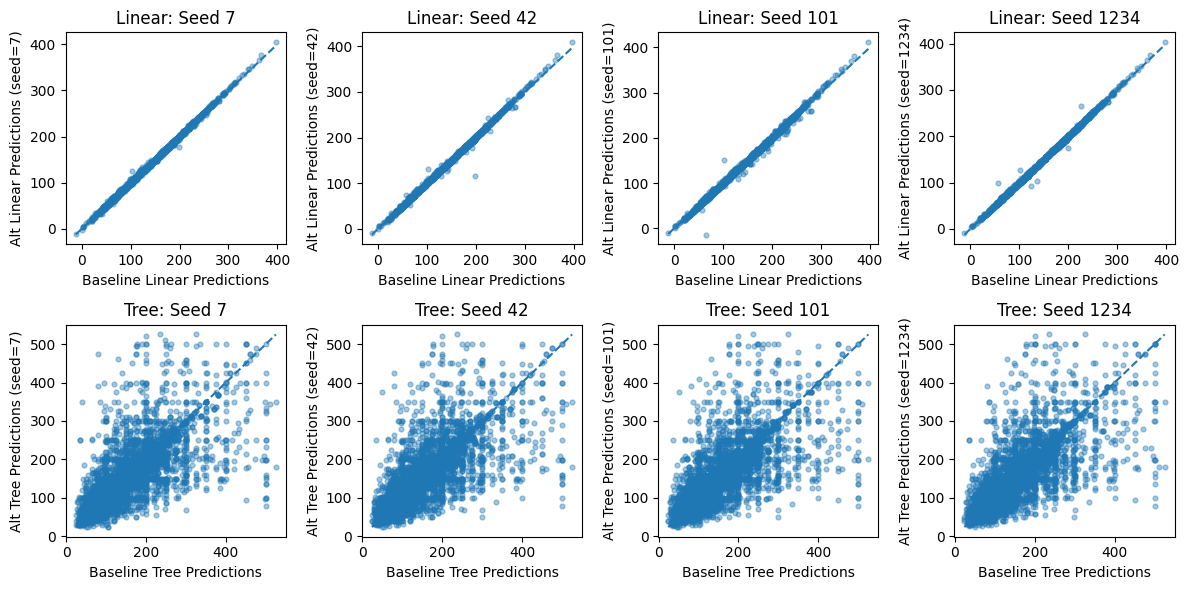

CORRELATIONS BETWEEN PART 2 AND PART 3 MODELS
    model  seed  correlation
0  linear     7     0.999755
1    tree     7     0.754674
2  linear    42     0.999535
3    tree    42     0.763250
4  linear   101     0.999267
5    tree   101     0.755558
6  linear  1234     0.999660
7    tree  1234     0.765781
REGRESSION OF ALT PREDICTIONS ON BASELINE PREDICTIONS 
    model  seed  intercept     slope        r2
0  linear     7  -0.839977  1.005663  0.999509
1    tree     7  35.680978  0.753071  0.569533
2  linear    42  -1.146211  1.008566  0.999071
3    tree    42  35.628695  0.755060  0.582550
4  linear   101  -0.979514  1.004849  0.998535
5    tree   101  36.170505  0.747546  0.570867
6  linear  1234  -0.124645  0.998202  0.999320
7    tree  1234  34.709167  0.757109  0.586421


In [16]:
# PART 4
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression


# (A) Scatterplots of baseline preds (Part 2) vs alternative preds (Part 3)
plt.figure(figsize=(12, 6))

for i, seed in enumerate(ALT_SEEDS):
    # ---- Linear Model Scatterplot ----
    plt.subplot(2, len(ALT_SEEDS), i+1)
    plt.scatter(yhat_lin_base, lin_alt[seed], alpha=0.4, s=12)
    plt.plot([yhat_lin_base.min(), yhat_lin_base.max()],
             [yhat_lin_base.min(), yhat_lin_base.max()],
             linestyle="--")
    plt.xlabel("Baseline Linear Predictions")
    plt.ylabel("Alt Linear Predictions (seed=" + str(seed) + ")")
    plt.title("Linear: Seed " + str(seed))

    # ---- Tree Model Scatterplot ----
    plt.subplot(2, len(ALT_SEEDS), len(ALT_SEEDS) + i + 1)
    plt.scatter(yhat_tree_base, tree_alt[seed], alpha=0.4, s=12)
    plt.plot([yhat_tree_base.min(), yhat_tree_base.max()],
             [yhat_tree_base.min(), yhat_tree_base.max()],
             linestyle="--")
    plt.xlabel("Baseline Tree Predictions")
    plt.ylabel("Alt Tree Predictions (seed=" + str(seed) + ")")
    plt.title("Tree: Seed " + str(seed))

plt.tight_layout()
plt.show()

# (B) Correlation 
rows = []

for seed in ALT_SEEDS:
    # convert to pandas Series for .corr()
    base_lin_series = pd.Series(yhat_lin_base)
    alt_lin_series = pd.Series(lin_alt[seed])
    base_tree_series = pd.Series(yhat_tree_base)
    alt_tree_series = pd.Series(tree_alt[seed])

    corr_lin = base_lin_series.corr(alt_lin_series)
    corr_tree = base_tree_series.corr(alt_tree_series)

    rows.append(["linear", seed, corr_lin])
    rows.append(["tree", seed, corr_tree])

corr_df = pd.DataFrame(rows, columns=["model", "seed", "correlation"])

print("CORRELATIONS BETWEEN PART 2 AND PART 3 MODELS")
print(corr_df)

# (C) REGRESSION 

rows = []

for seed in ALT_SEEDS:
    # ----- Linear Model -----
    base_lin = pd.Series(yhat_lin_base).values.reshape(-1, 1)
    alt_lin  = pd.Series(lin_alt[seed]).values

    reg_lin = LinearRegression()
    reg_lin.fit(base_lin, alt_lin)

    rows.append([
        "linear",
        seed,
        reg_lin.intercept_,
        reg_lin.coef_[0],
        reg_lin.score(base_lin, alt_lin)
    ])

    # ----- Tree Model -----
    base_tree = pd.Series(yhat_tree_base).values.reshape(-1, 1)
    alt_tree  = pd.Series(tree_alt[seed]).values

    reg_tree = LinearRegression()
    reg_tree.fit(base_tree, alt_tree)

    rows.append([
        "tree",
        seed,
        reg_tree.intercept_,
        reg_tree.coef_[0],
        reg_tree.score(base_tree, alt_tree)
    ])

regression_df = pd.DataFrame(
    rows,
    columns=["model", "seed", "intercept", "slope", "r2"]
)

print("REGRESSION OF ALT PREDICTIONS ON BASELINE PREDICTIONS ")
print(regression_df)




QUESTION 4

A) The scatterplot has the baseline predictions from Part 2 and the alternative seeds in Part 3. The scatterplots show that the linear models produce extremely similar predictions across all seeds. The decision tree shows much more contrast in comparison to the linear model. The points in the decision tree are much more dispersed which show that the trees changes substantially with different splits. 

B) The correlation results show that the linear models are extremely highly correlated across train/test spits with the results at 0.99 consistently across the board. This indicates that the change in seed had no effect on the linear model's predictions. In constrast, the tree predictions are only mdoerately correlated. Many of teh results ranged from 0.75-0.77 whihc is much lower than the results we saw in the linear model. This shows that for the deicision tree, the results vary much more based on the seed. 

C) Once again, the regression on the linear models are extremely stable across all seeds. In the lienar model, the results are veery close to 0, the slope is almost exactly at 1, and r^2 is almost at 1 as well. In contrast, the decision tree results are far less stable. Their interecepts were very large, the slopes were well below 1, and the r^2 are much lower usually ranging around 0.5. 

QUESTION 5

Yes, the linear models are very stable, with predictions that line up almost perfectly across all train and test splits and coefficients that barely change. The decision trees, however, vary a lot from split to split, producing different patterns each time. This shows that linear models are consistent, while trees are much more sensitive to how the data is split.

QUESTION 6

True, the two models can look very different internally but still make very similar predictions, especially if they capture the same underlying signal in the data. This often happens when the target is driven by strong, stable relationships that multiple model structures can approximate equally well.